In [27]:
import numpy as np
import matplotlib.pyplot as plt
import os 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms, datasets

In [28]:
train_dir = '/home/jovyan/cifar10-practice/data/processed/cifar10_original_png/train'
test_dir = '/home/jovyan/cifar10-practice/data/processed/cifar10_original_png/test'
model_output_path = '/home/jovyan/cifar10-practice/models/cifar10.pt'

In [29]:
BATCH_SIZE = 32
EPOCHS = 10

In [30]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.10.0+cu102  Device: cpu


In [31]:
train_data = datasets.ImageFolder(root=train_dir, transform=transforms.ToTensor())
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)

test_data = datasets.ImageFolder(root=test_dir, transform=transforms.ToTensor())
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)

print(f'train_sample_num: {len(train_data)}')
print(f'test_sample_num: {len(test_data)}')

train_sample_num: 50000
test_sample_num: 10000


In [32]:
if train_data.class_to_idx == test_data.class_to_idx:
    class_to_idx = train_data.class_to_idx
    idx_to_class = {idx: name for name, idx in class_to_idx.items()}
    display(idx_to_class)

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [33]:
for (x_train, y_train) in train_loader:
    print('x_train:', x_train.size(), 'type:', x_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

x_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


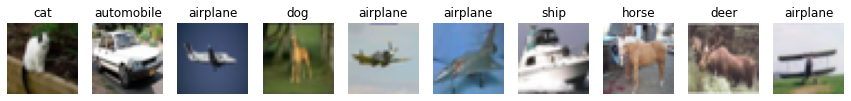

In [34]:
pltsize = 1.5
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(x_train[i], (1, 2, 0)))
    plt.title(idx_to_class[y_train[i].item()])

In [35]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [36]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [37]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [38]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [39]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.299627


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), model_output_path)

model_size = os.path.getsize(model_output_path)
model_size_kb = int(model_size / 1000)
print(f'saved_model_size: {model_size_kb} [kb]')

In [40]:
new_model_path = '/home/jovyan/cifar10-practice/models/cifar10-65.20.pt'

In [41]:
model_reloaded = torch.load(new_model_path)
loaded_model = CNN().to(DEVICE)
loaded_model.load_state_dict(model_reloaded)

<All keys matched successfully>

In [43]:
from PIL import Image

test_img_path = '/home/jovyan/cifar10-practice/data/processed/cifar10_original_png/test/bird/00067.png'
img_to_tensor = transforms.ToTensor()

test_img = Image.open(test_img_path)
test_img_tensor = img_to_tensor(test_img)
test_img_stack = torch.stack((test_img_tensor,)).to(DEVICE)

proba_logsoftmax = loaded_model(test_img_stack).tolist()[0]
proba = [np.exp(val) for val in proba_logsoftmax]
proba_max = max(proba)
proba_max_idx = np.argmax(proba)
pred_class = idx_to_class[proba_max_idx]
print(pred_class, proba_max)

bird 0.6601915246381649


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
